In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
from gl_functions import *
from spot_functions import *

In [3]:
#### CONSTANTS ####
obj_search_cam_coords = [{'moveTo':[0.35, 0.4, 0.5], 'lookAt':[0.35, 0.6, -0.5]}, 
                      {'moveTo':[0.6, 0.0, 0.5],  'lookAt':[1.0, 0.0, -0.5]},
                      {'moveTo':[0.35, -0.4, 0.5],'lookAt':[0.35, -0.6, -0.5]}]

timeout_sec = 10

In [4]:
sdk, robot, id_client, \
robot_state_client, command_client, \
image_client, graph_nav_client, \
world_object_client, manipulation_api_client = init_robot('192.168.50.3')

In [5]:
lease_client, lease, lease_keep_alive = get_lease(robot)

In [6]:
# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)
detectors = gl.list_detectors()
can_det = detectors.results[0]

In [93]:
get_batt_info(robot_state_client)

Battery at: 18.0 %. Robot has 1035 seconds left


(18.0, 1035)

In [10]:
success = power_on(robot)

True


In [11]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeout_sec)

In [91]:
def obj_search(command_client, image_client, gl, obj_det, verbose = False):
    tree = None
    hand_color = None

    for hand_pos_ind in range(len(obj_search_cam_coords)):

        cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
        cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

        move_to_and_look_at(command_client, 
                        obj_search_cam_coords[hand_pos_ind]['moveTo'], 
                        obj_search_cam_coords[hand_pos_ind]['lookAt'])
        time.sleep(0.5)
        hand_color_img, image_response = cap_hand_image(image_client, 'hand_color_image')
        time.sleep(0.1)
        tree = sweep_localize(gl, obj_det, hand_color_img, verbose = verbose)

        if tree is not None:
            print('found OBJ')
            return tree, hand_color_img, image_response
    print('FAILED TO FIND OBJ')
    return None, None, None

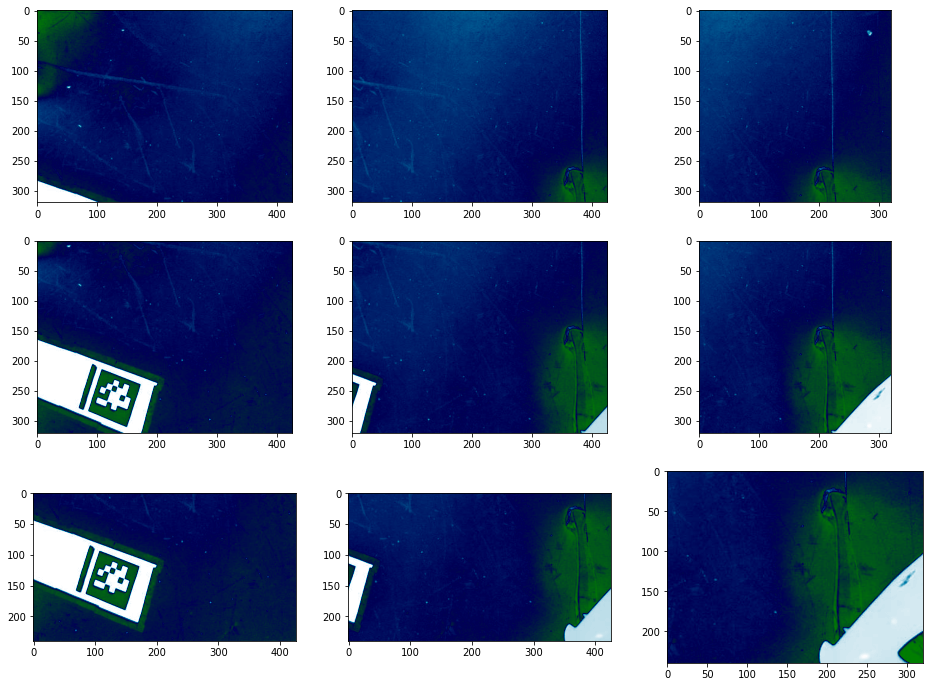

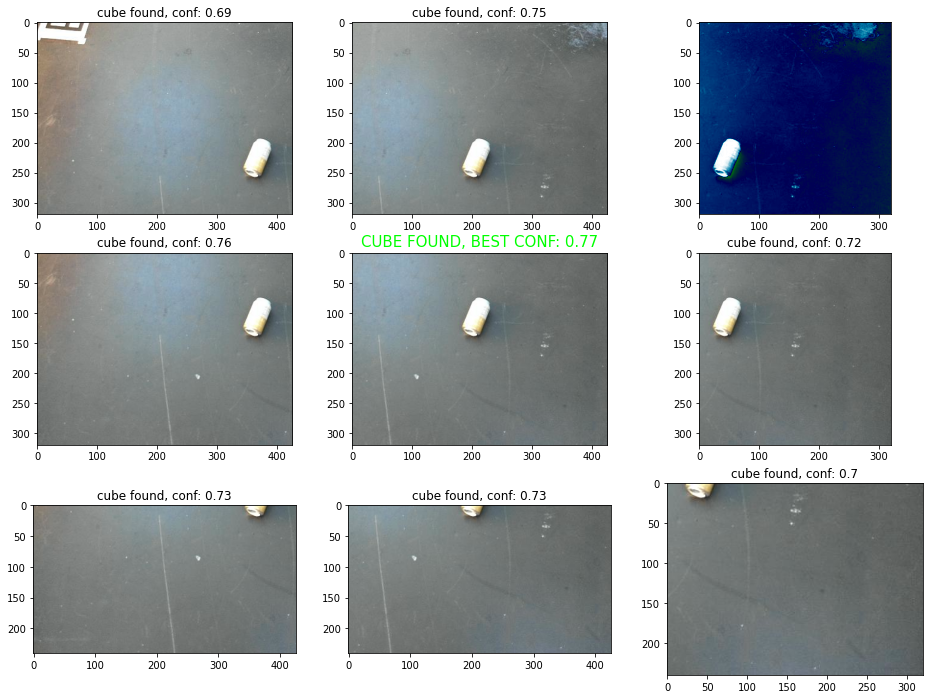

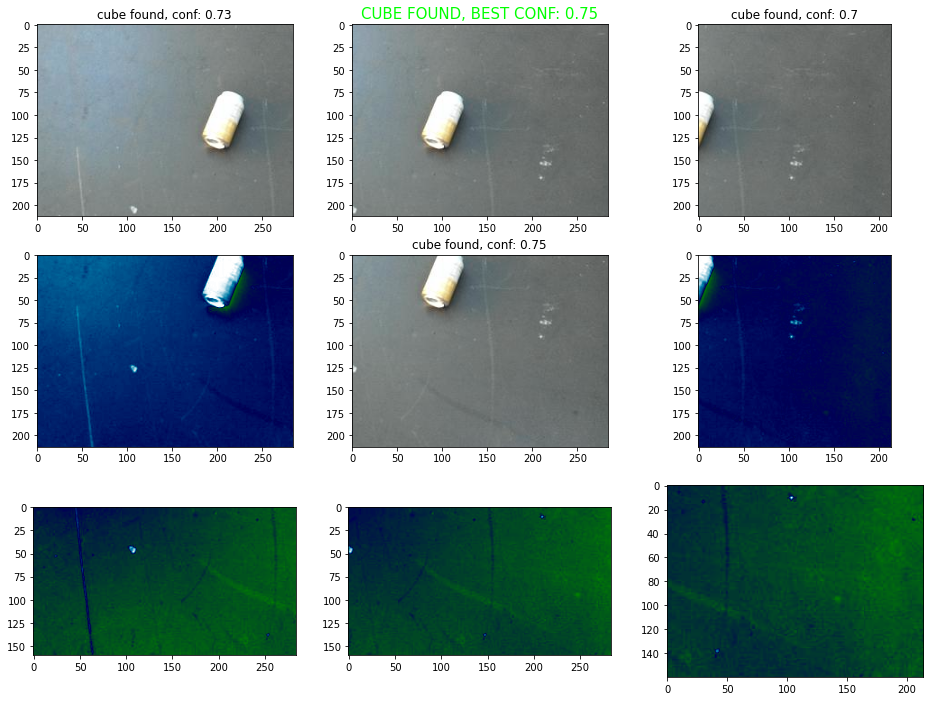

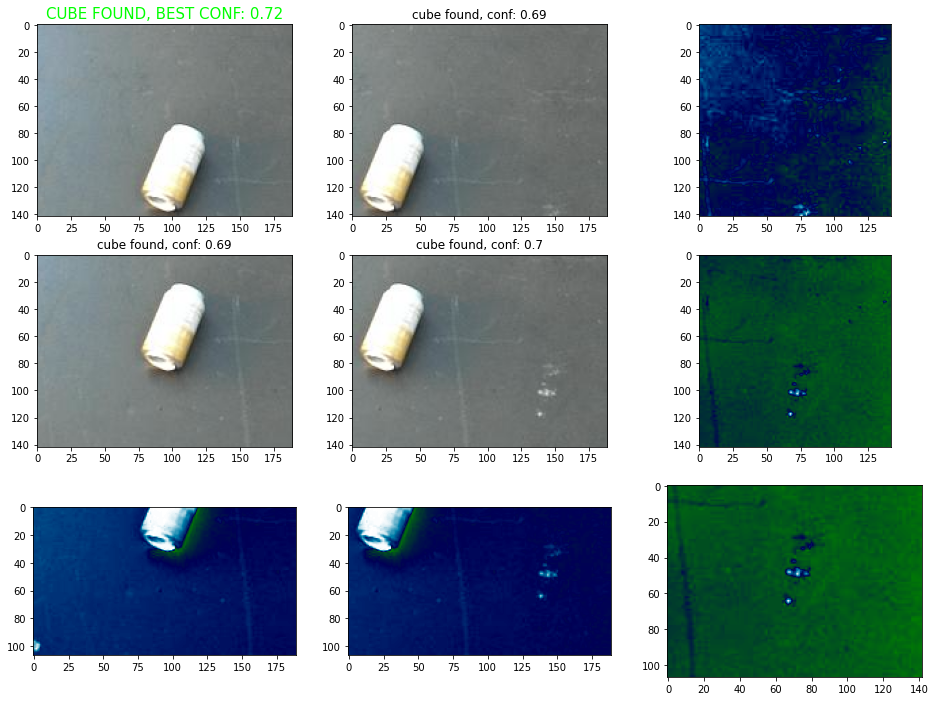

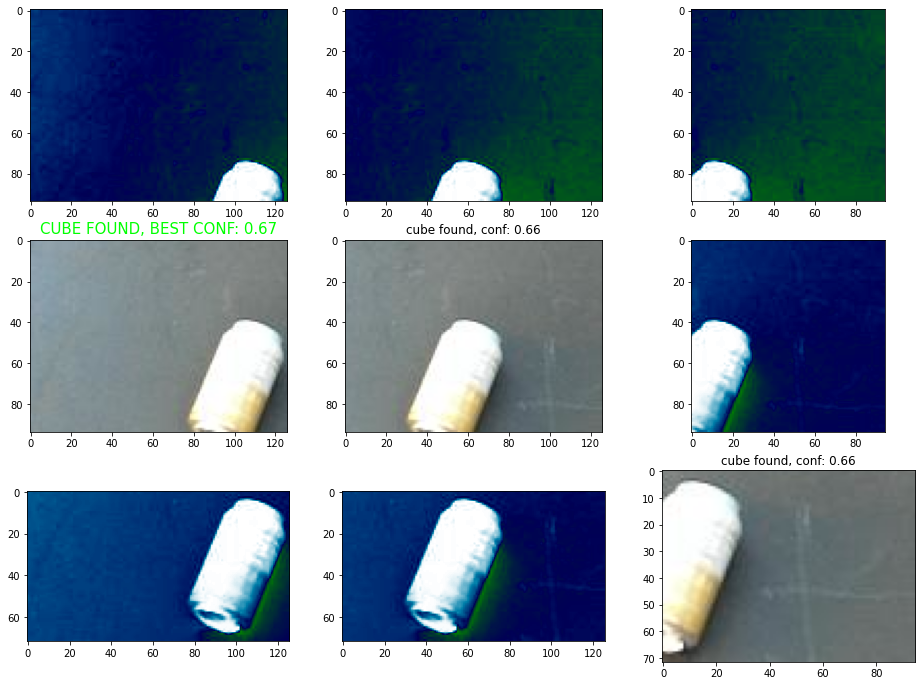

found OBJ


<AxesSubplot:>

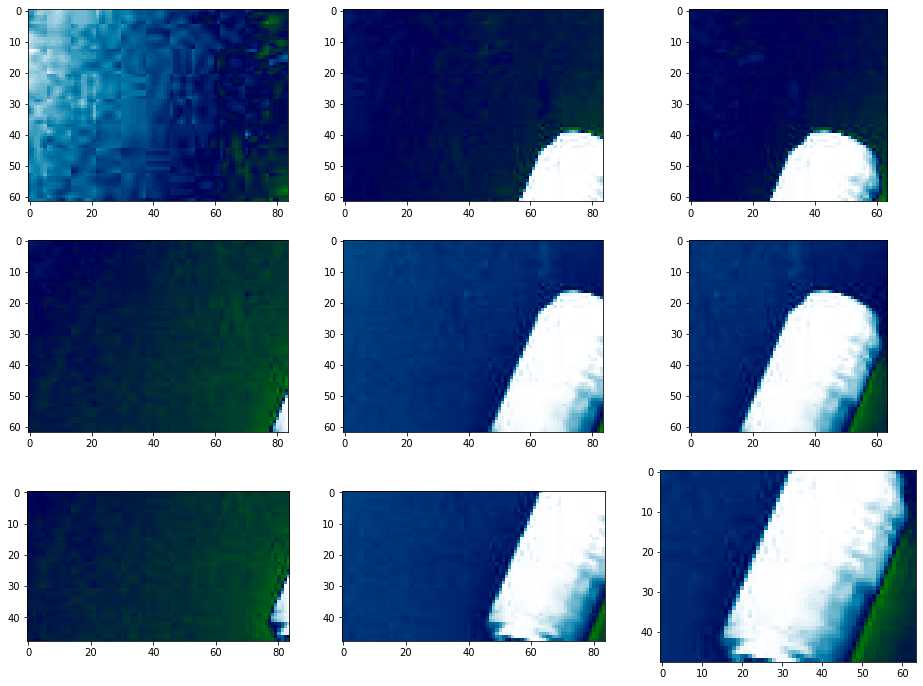

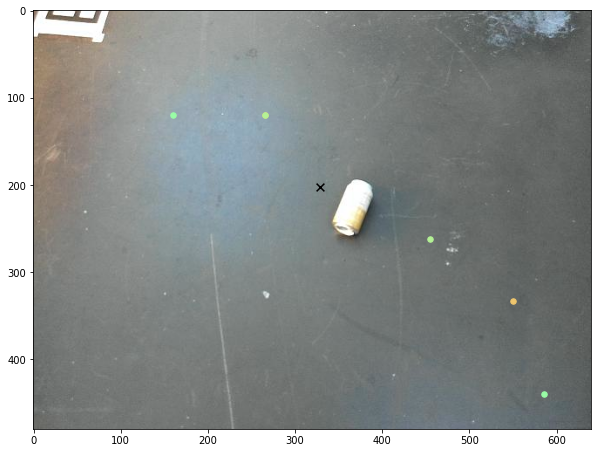

In [92]:
tree, hand_color_img, image_response = obj_search(command_client, image_client, gl, can_det, verbose = True)
fig, ax = plt.subplots(1,1, figsize = (10,8))
plot_tree_on_image(ax, tree, hand_color_img)

In [83]:
upload_filepath = "/home/gluser/groundlight/bdspot/spot/loopGraph"
upload_graph_and_snapshots(graph_nav_client, upload_filepath)
success = graph_localize_fiducial(command_client, graph_nav_client, robot_state_client, robot)
waypoint_list = create_waypoint_list(graph_nav_client)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
attempt #:  0
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  1
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  2
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  3
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  4
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  5
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  6
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  7
FAILED: could not perform fidicial init, will shift and re-attempt
attempt #:  8
SUCCESS: initialized location to using nearest fiducial


In [84]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[9], cmd_duration = 15)

In [39]:
#loop_waypoints = [25, 5, 6, 9, 10, 12, 15, 17, 18, 19, 20, 21, 23, 24]

def loop_until_grasp(graph_nav_client, 
                     command_client, 
                     image_client, 
                     manipulation_api_client,
                     loop_waypoints = [9, 10, 12],
                     verbose = False):
    while True:
        for waypoint_ind in loop_waypoints:
            nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[waypoint_ind], cmd_duration = 15)
            wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)

            wp_loc_proto = graph_del_get_graph_loc(graph_nav_client)

            tree, hand_color_img, image_response = obj_search(command_client, image_client, gl, can_det, verbose = verbose)
            
            cmd = RobotCommandBuilder.arm_stow_command()
            cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

            if tree is None:
                upload_graph_and_snapshots(graph_nav_client, upload_filepath)
#                 try:
#                     print('attempting to localize with guess')
#                     graph_localize_guess(graph_nav_client, robot_state_client, wp_loc_proto)
#                 except bosdyn.client.graph_nav.RequestFailedError as e:
#                     print('FAILED TO LOCALIZE WITH GUESS, FINDING FIDUCIAL NOW')
                graph_localize_fiducial(command_client, graph_nav_client, robot_state_client, robot)
                continue

            pxLoc = assemble_px_tree(tree)
            pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])
            grasp = manipulation_api_pb2.PickObjectInImage(
                pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
                frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
                camera_model=image_response.source.pinhole)#, grasp_params = graspParams)
            grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)
            response, success = make_grasp(grasp_request, manipulation_api_client, command_client, graph_nav_client, verbose = verbose)
        
            return response, success, tree, hand_color_img

    

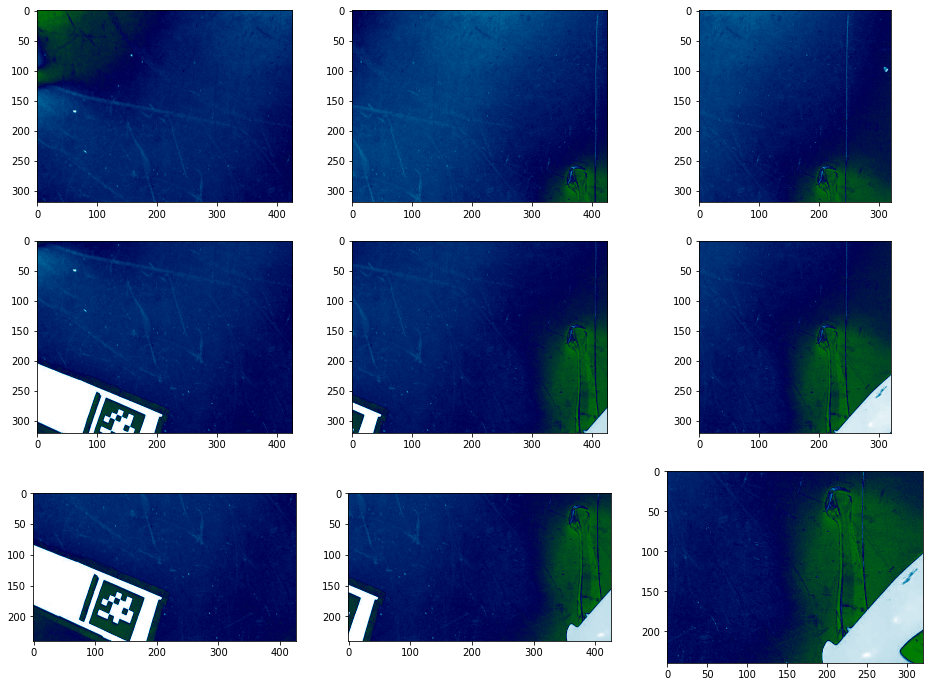

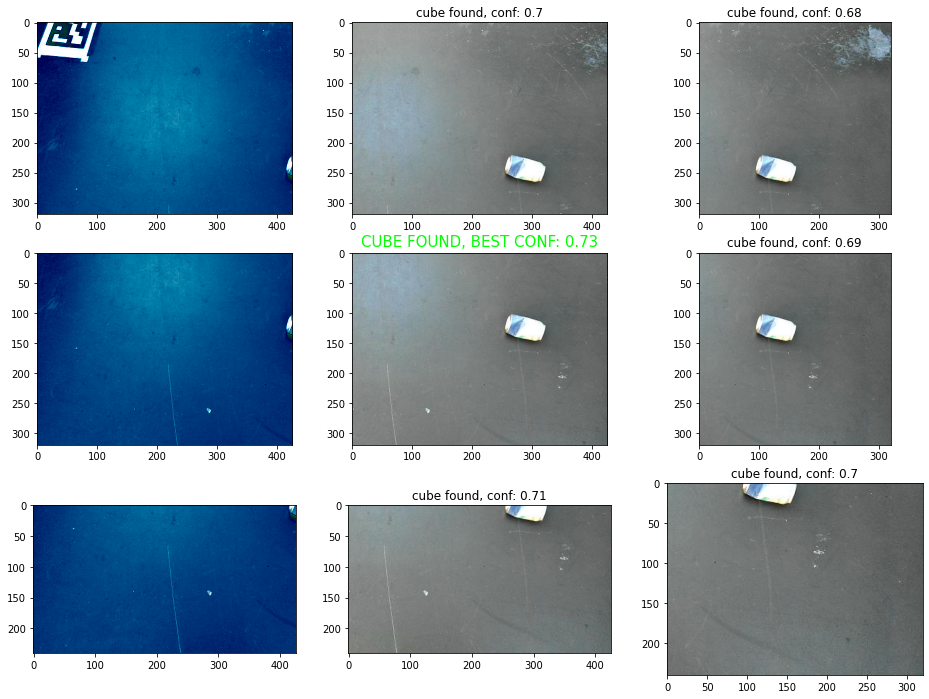

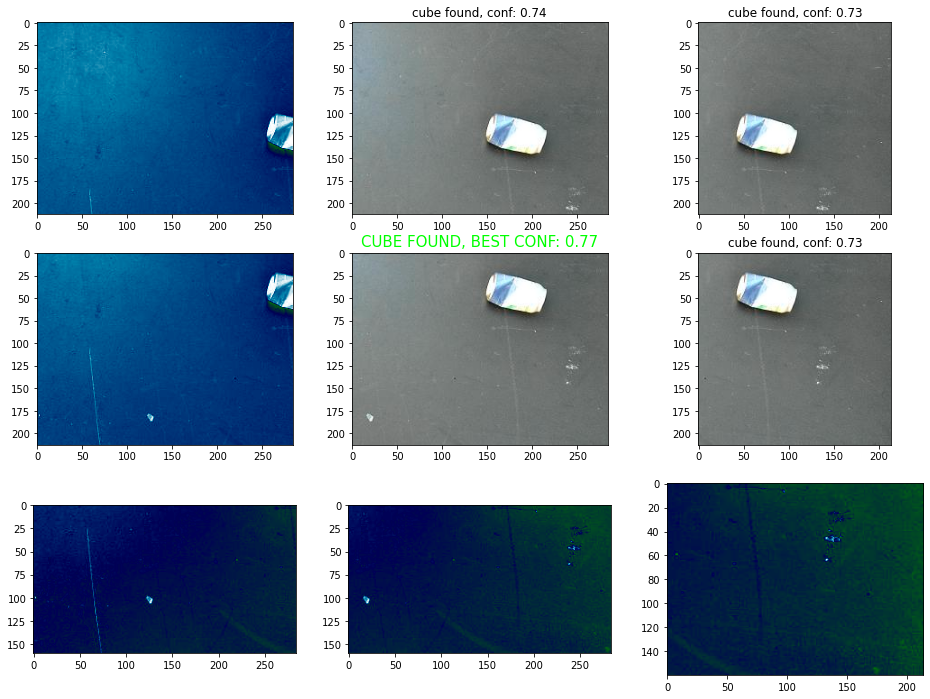

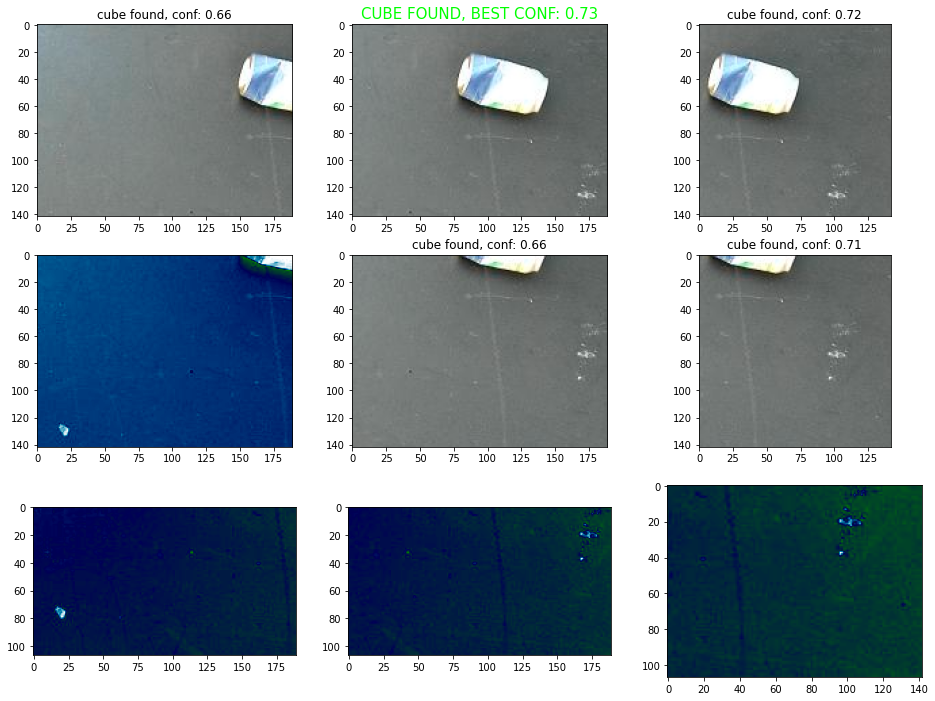

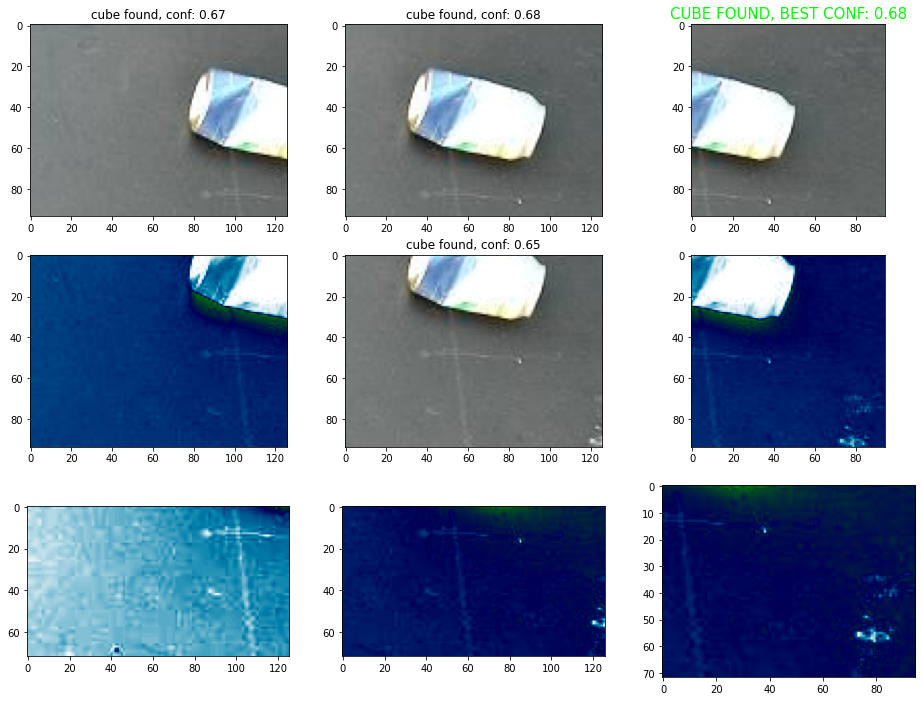

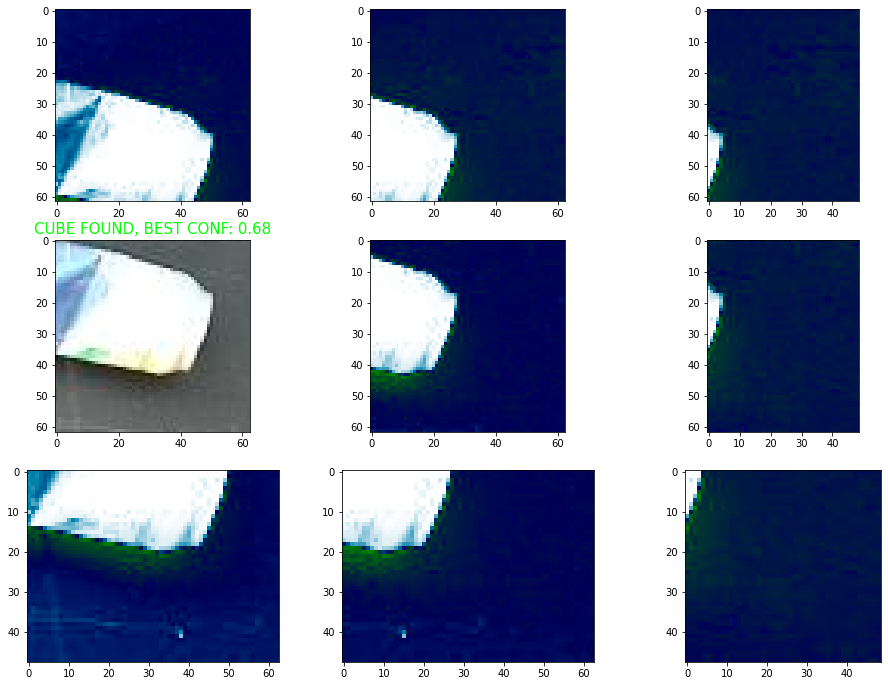

found OBJ
Current state:  MANIP_STATE_ATTEMPTING_RAYCASTING
Current state:  MANIP_STATE_WALKING_TO_OBJECT
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Cu

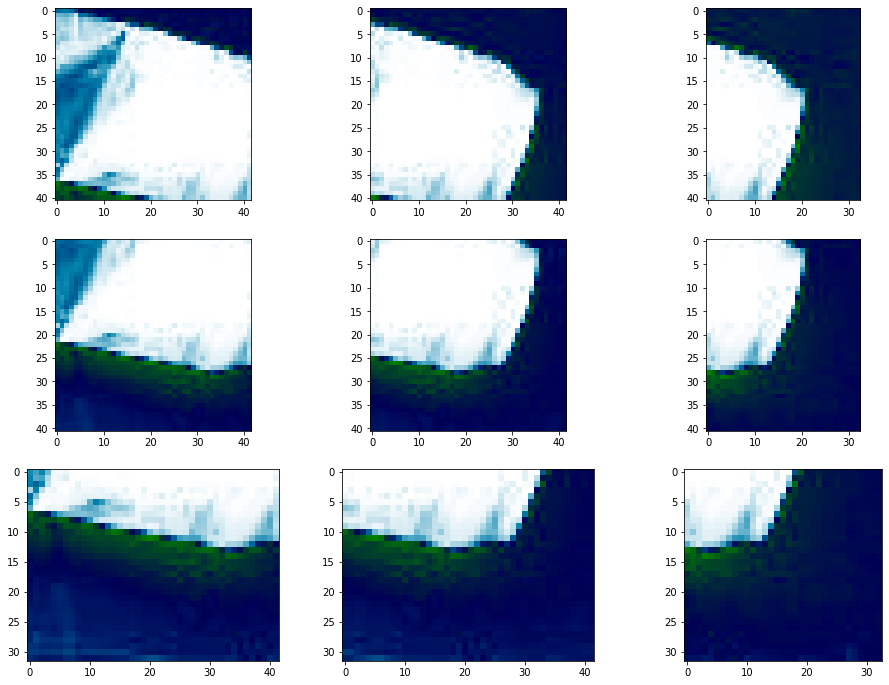

In [40]:
response, success, tree, hand_color_img = loop_until_grasp(graph_nav_client, command_client, image_client, manipulation_api_client)

In [77]:
def get_recycle_coords(world_object_client,):
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == 579:
            fid = fiducial_obj

    if fid is None:
        print("COULD NOT FIND RECYCLING CAN RETURNING NONE")
        return None


    fid_tree_snapshot = fid.transforms_snapshot
    frame_tree_snapshot = robot.get_frame_tree_snapshot()

    #get_a_tform_b returns transformation such that a_coords = tform * b_coords

    fid_to_vision = bosdyn.client.frame_helpers.get_a_tform_b(fid_tree_snapshot, frame_a = 'vision', frame_b ='filtered_fiducial_579')
    
    return fid_to_vision

In [78]:
fid_to_vision = get_recycle_coords(world_object_client)

In [79]:
drop_pose_fid_frame_proto = geometry_pb2.SE3Pose(
    position = geometry_pb2.Vec3(x = 0.3, y = 0, z = -0.1), 
    rotation = bosdyn.client.math_helpers.Quat(w = 0, 
                                               x = 0, 
                                               y = -(1/2)**0.5, 
                                               z = (1/2)**0.5).to_proto())
    #rotation = (bosdyn.client.math_helpers.Quat(1, 0, 0, 0).normalize()).to_obj())
    #rotation = geometry_pb2.Quaternion(w = , x = 0, y = 0, z = 0))

drop_pose_fid_frame_se3 = bosdyn.client.math_helpers.SE3Pose.from_proto(drop_pose_fid_frame_proto)

drop_pose_vision_frame_se3 = (fid_to_vision * drop_pose_fid_frame_se3)

In [80]:
print("pitch", drop_pose_vision_frame_se3.rotation.to_pitch())
print("roll", drop_pose_vision_frame_se3.rotation.to_roll())
print("yaw", drop_pose_vision_frame_se3.rotation.to_roll())

pitch 1.4917434654093822
roll 2.0157982322788577
yaw 2.0157982322788577


In [81]:
body_cmd = RobotCommandBuilder.follow_arm_command()
arm_cmd = RobotCommandBuilder.arm_pose_command(x = drop_pose_vision_frame_se3.x,
                                           y = drop_pose_vision_frame_se3.y,
                                           z = drop_pose_vision_frame_se3.z,
                                           qw = drop_pose_vision_frame_se3.rotation.w,
                                           qx = drop_pose_vision_frame_se3.rotation.x,
                                           qy = drop_pose_vision_frame_se3.rotation.y,
                                           qz = drop_pose_vision_frame_se3.rotation.z,
                                           frame_name = 'vision')
cmd = RobotCommandBuilder.build_synchro_command(body_cmd, arm_cmd)

cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [82]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
time.sleep(1.0)

cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [30]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[9], cmd_duration = 15)

RobotNotLocalizedToRouteError: bosdyn.api.graph_nav.NavigateToResponse (RobotNotLocalizedToRouteError): The current localization doesn't refer to any waypoint in the route (possibly uninitialized localization).

In [90]:
wp_loc_proto = graph_del_get_graph_loc(graph_nav_client)

In [ ]:
def random_cube_drop(command_client):
    randomLookDir = [((np.random.rand() * 2) - 1) * 2, 
                 (((np.random.rand()) * 2) - 1) * 3, 
                 np.random.rand() * (-2)  ]

    move_to_and_look_at(command_client, [0.8,0,-0.35],randomLookDir, True)
    
    time.sleep(0.5)

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

    time.sleep(0.5)

    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [57]:
# move_robot_relative(command_client, robot, 0.5, 0.2, 0)

In [43]:
# upload_graph_and_snapshots(graph_nav_client, upload_filepath)
# response = graphLocalizeGuess(graph_nav_client, wp_loc_proto)

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize
